In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, balanced_accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
import xgboost
from scipy.constants import G

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_koi = pd.read_csv(r'D:\exoplanets\data\koi\koi.csv')
df_toi = pd.read_csv(r'D:\exoplanets\data\toi\toi.csv')
df_k2 = pd.read_csv(r'D:\exoplanets\data\k2\k2.csv')

In [3]:
df_koi.columns

Index(['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition',
       'koi_vet_stat', 'koi_vet_date', 'koi_pdisposition', 'koi_score',
       'koi_fpflag_nt',
       ...
       'koi_dicco_mdec', 'koi_dicco_mdec_err', 'koi_dicco_msky',
       'koi_dicco_msky_err', 'koi_dikco_mra', 'koi_dikco_mra_err',
       'koi_dikco_mdec', 'koi_dikco_mdec_err', 'koi_dikco_msky',
       'koi_dikco_msky_err'],
      dtype='object', length=141)

In [4]:
koi_useful_columns = ['koi_disposition', 'koi_pdisposition', 'koi_score', 'koi_period',
                  'koi_impact', 'koi_duration', 'koi_depth', 'koi_ror', 'koi_srho', 'koi_prad', 'koi_sma', 'koi_incl', 'koi_teq',
                  'koi_insol', 'koi_dor', 'koi_ldm_coeff2', 'koi_ldm_coeff1', 'koi_max_sngle_ev', 'koi_max_mult_ev',
                  'koi_model_snr', 'koi_count', 'koi_num_transits', 'koi_steff', 'koi_slogg', 'koi_smet', 'koi_srad', 'koi_smass', 'ra',
                  'dec', 'koi_kepmag', 'koi_gmag', 'koi_rmag', 'koi_imag', 'koi_zmag', 'koi_jmag', 'koi_hmag', 'koi_kmag', 'koi_time0bk']

In [5]:
toi_useful_columns = ['pl_pnum', 'tfopwg_disp', 'ra', 'dec', 'st_pmra', 'st_pmdec', 'pl_tranmid', 'pl_orbper', 'pl_trandurh',
                      'pl_trandep', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_tmag', 'st_dist', 'st_teff', 'st_logg', 'st_rad']

In [6]:
k2_useful_columns = ['disposition', 'sy_snum', 'sy_pnum', 'rv_flag', 'tran_flag',
                     'micro_flag', 'pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_radj', 'pl_masse', 'pl_massj', 'pl_msinie',
                     'pl_msinij', 'pl_cmasse', 'pl_cmassj', 'pl_bmasse', 'pl_bmassj', 'pl_dens', 'pl_orbeccen', 'pl_insol', 'pl_eqt', 'pl_orbincl', 'pl_tranmid',
                     'ttv_flag', 'pl_imppar', 'pl_trandep', 'pl_trandur', 'pl_ratdor', 'pl_ratror', 'pl_orbtper', 'pl_orblper', 'pl_rvamp',
                     'pl_projobliq', 'pl_trueobliq', 'st_spectype', 'st_teff', 'st_rad', 'st_mass', 'st_met', 'st_metratio', 'st_lum', 'st_logg', 'st_age',
                     'st_dens', 'st_vsin', 'st_rotp', 'st_radv', 'sy_pm', 'sy_pmra', 'sy_pmdec', 'sy_dist', 'sy_plx', 'rastr', 'decstr', 'ra', 'dec', 'glat', 'glon',
                     'elat', 'elon', 'sy_bmag', 'sy_vmag', 'sy_jmag', 'sy_hmag', 'sy_gmag', 'sy_rmag', 'sy_imag', 'sy_zmag', 'sy_w1mag',
                     'sy_w2mag', 'sy_w3mag', 'sy_w4mag', 'sy_gaiamag', 'sy_tmag', 'sy_kepmag']

In [7]:
koi_cleaned = df_koi[koi_useful_columns]
toi_cleaned = df_toi[toi_useful_columns]
k2_cleaned = df_k2[k2_useful_columns]

In [8]:
koi_fp = koi_cleaned[(koi_cleaned['koi_disposition'] == 'FALSE POSITIVE')|(koi_cleaned['koi_pdisposition'] == 'FALSE POSITIVE')]
koi_diff = koi_fp[koi_fp['koi_disposition'] != koi_fp['koi_pdisposition']]
diff_ind = koi_diff.index

In [9]:
koi_cleaned.drop(index = diff_ind, inplace = True)
koi_cleaned.drop(columns = ['koi_pdisposition'], inplace = True)

koi_cleaned['is_planet'] = koi_cleaned['koi_disposition'].apply(lambda x: 1 if x != 'FALSE POSITIVE' else 0)
koi_cleaned.drop(columns = ['koi_disposition'], inplace = True)

In [10]:
target_simplifier = {'CP': 1, 'KP': 1, 'FA': 0, 'FP': 0}
toi_cleaned['is_planet'] = toi_cleaned['tfopwg_disp'].map(target_simplifier)
toi_cleaned.drop(columns = ['tfopwg_disp'], inplace = True)

In [11]:
k2_cleaned = k2_cleaned[k2_cleaned['disposition'].isin(['CONFIRMED', 'FALSE POSITIVE'])]
k2_cleaned['is_planet'] = k2_cleaned['disposition'].apply(lambda x: 1 if x == 'CONFIRMED' else 0)
k2_cleaned.drop(columns = ['disposition'], inplace = True)

In [12]:
koi_cleaned = koi_cleaned.rename(
    columns = {
        'is_planet': 'is_planet',
        'koi_count': 'planet_count',
        'ra': 'right_ascens',
        'dec': 'declination',
        'koi_time0bk': 'mid_trans_time',
        'koi_period': 'period',
        'koi_duration': 'trans_duration',
        'koi_depth': 'trans_depth',
        'koi_prad': 'planet_radius',
        'koi_insol': 'planet_insolation',
        'koi_teq': 'planet_temp',
        'koi_steff': 'stellar_temp',
        'koi_slogg': 'stellar_logg',
        'koi_srad': 'stellar_radius'
    }
)

toi_cleaned = toi_cleaned.rename(
    columns = {
        'is_planet': 'is_planet',
        'pl_pnum': 'planet_count',
        'ra': 'right_ascens',
        'dec': 'declination',
        'pl_tranmid': 'mid_trans_time',
        'pl_orbper': 'period',
        'pl_trandurh': 'trans_duration',
        'pl_trandep': 'trans_depth',
        'pl_rade': 'planet_radius',
        'pl_insol': 'planet_insolation',
        'pl_eqt': 'planet_temp',
        'st_teff': 'stellar_temp',
        'st_logg': 'stellar_logg',
        'st_rad': 'stellar_radius'
    }
)

k2_cleaned = k2_cleaned.rename(
    columns = {
        'is_planet': 'is_planet',
        'sy_pnum': 'planet_count',
        'ra': 'right_ascens',
        'dec': 'declination',
        'pl_tranmid': 'mid_trans_time',
        'pl_orbper': 'period',
        'pl_trandur': 'trans_duration',
        'pl_trandep': 'trans_depth',
        'pl_rade': 'planet_radius',
        'pl_insol': 'planet_insolation',
        'pl_eqt': 'planet_temp',
        'st_teff': 'stellar_temp',
        'st_logg': 'stellar_logg',
        'st_rad': 'stellar_radius'
    }
)

In [13]:
koi_cleaned['trans_depth'] = koi_cleaned['trans_depth'] / 1000000
toi_cleaned['trans_depth'] = toi_cleaned['trans_depth'] / 1000000
k2_cleaned['trans_depth'] = k2_cleaned['trans_depth'] / 100

In [14]:
absent = ['st_pmra', 'st_pmdec', 'st_tmag', 'st_dist']

In [15]:
common_columns = ['is_planet', 'right_ascens', 'declination', 'period', 'trans_duration', 'trans_depth', 'planet_radius', 'planet_temp', 'stellar_temp',
                  'stellar_logg', 'stellar_radius']

In [16]:
koi_cleaned

,koi_score,period,koi_impact,trans_duration,trans_depth,koi_ror,koi_srho,planet_radius,koi_sma,koi_incl,...,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,mid_trans_time,is_planet
0,1.000,9.488036,0.146,2.95750,0.000616,0.022344,3.20796,2.26,0.0853,89.66,...,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,170.538750,1
1,0.969,54.418383,0.586,4.50700,0.000875,0.027954,3.02368,2.83,0.2734,89.57,...,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,162.513840,1
2,0.000,19.899140,0.969,1.78220,0.010829,0.154046,7.29555,14.60,0.1419,88.96,...,15.436,15.943,15.390,15.220,15.166,14.254,13.900,13.826,175.850252,1
3,0.000,1.736952,1.276,2.40641,0.008079,0.387394,0.22080,33.46,0.0267,67.09,...,15.597,16.100,15.554,15.382,15.266,14.326,13.911,13.809,170.307565,0
4,1.000,2.525592,0.701,1.65450,0.000603,0.024064,1.98635,2.75,0.0374,85.41,...,15.509,16.015,15.468,15.292,15.241,14.366,14.064,13.952,171.595550,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,0.000,0.527699,1.252,3.22210,0.001579,0.297633,0.16318,29.35,0.0128,20.78,...,14.082,14.082,13.501,13.299,13.177,12.200,11.814,11.756,131.705093,0
9560,0.497,1.739849,0.043,3.11400,0.000048,0.006379,0.50770,0.72,0.0290,89.42,...,14.757,15.189,14.687,14.571,14.484,13.641,13.339,13.261,133.001270,1
9561,0.021,0.681402,0.147,0.86500,0.000104,0.009444,8.97692,1.07,0.0157,88.60,...,15.385,15.853,15.347,15.185,15.158,14.220,13.913,13.844,132.181750,0
9562,0.092,333.486169,0.214,3.19900,0.000639,0.022590,85.88623,19.30,1.2233,89.98,...,10.998,11.733,10.880,10.682,10.578,9.501,9.027,8.921,153.615010,1


In [17]:
koi_cleaned.columns

Index(['koi_score', 'period', 'koi_impact', 'trans_duration', 'trans_depth',
       'koi_ror', 'koi_srho', 'planet_radius', 'koi_sma', 'koi_incl',
       'planet_temp', 'planet_insolation', 'koi_dor', 'koi_ldm_coeff2',
       'koi_ldm_coeff1', 'koi_max_sngle_ev', 'koi_max_mult_ev',
       'koi_model_snr', 'planet_count', 'koi_num_transits', 'stellar_temp',
       'stellar_logg', 'koi_smet', 'stellar_radius', 'koi_smass',
       'right_ascens', 'declination', 'koi_kepmag', 'koi_gmag', 'koi_rmag',
       'koi_imag', 'koi_zmag', 'koi_jmag', 'koi_hmag', 'koi_kmag',
       'mid_trans_time', 'is_planet'],
      dtype='object')

In [18]:
koi_trunc = koi_cleaned[common_columns]
toi_trunc = toi_cleaned[common_columns]
k2_trunc = k2_cleaned[common_columns]

In [19]:
trunc = pd.concat([koi_trunc, toi_trunc, k2_trunc], ignore_index = True)

In [20]:
koi_trunc['stellar_mass'] = 10 ** koi_trunc['stellar_logg'] * koi_trunc['stellar_radius'] ** 2 / 27415.74171927881
koi_trunc['semi_major_axis'] = np.cbrt(koi_trunc['stellar_mass'] * koi_trunc['period'] ** 2) / 51.06693175314012
koi_trunc['impact'] = np.sqrt((1 + koi_trunc['planet_radius'] / koi_trunc['stellar_radius']) ** 2 \
                          - (np.pi * koi_trunc['semi_major_axis'] * koi_trunc['trans_duration'] / (koi_trunc['period'] * koi_trunc['stellar_radius'])) ** 2) / 107


In [21]:
trunc['stellar_mass'] = 10 ** trunc['stellar_logg'] * trunc['stellar_radius'] ** 2 / 27415.74171927881
trunc['semi_major_axis'] = np.cbrt(trunc['stellar_mass'] * trunc['period'] ** 2) / 51.06693175314012
trunc['impact'] = np.sqrt((1 + trunc['planet_radius'] / trunc['stellar_radius']) ** 2 \
                          - (np.pi * trunc['semi_major_axis'] * trunc['trans_duration'] / (trunc['period'] * trunc['stellar_radius'])) ** 2) / 107

#trunc['inclination'] = np.arccos(trunc['impact'] * trunc['stellar_radius'] / trunc['semi_major_axis'])

In [22]:
koi_trunc.drop(columns = ['stellar_mass', 'semi_major_axis', 'stellar_logg'], inplace = True)

In [23]:
trunc.drop(columns = ['stellar_mass', 'semi_major_axis', 'stellar_logg'], inplace = True)

In [24]:
trunc

,is_planet,right_ascens,declination,period,trans_duration,trans_depth,planet_radius,planet_temp,stellar_temp,stellar_radius,impact
0,1.0,291.934230,48.141651,9.488036,2.957500,0.000616,2.26000,793.00,5455.0,0.927000,0.032120
1,1.0,291.934230,48.141651,54.418383,4.507000,0.000875,2.83000,443.00,5455.0,0.927000,0.037870
2,1.0,297.004820,48.134129,19.899140,1.782200,0.010829,14.60000,638.00,5853.0,0.868000,0.166544
3,0.0,285.534610,48.285210,1.736952,2.406410,0.008079,33.46000,1395.00,5805.0,0.791000,0.404679
4,1.0,288.754880,48.226200,2.525592,1.654500,0.000603,2.75000,1406.00,6031.0,1.046000,0.033909
...,...,...,...,...,...,...,...,...,...,...,...
19856,1.0,175.908033,6.563784,2.655676,2.617200,0.014877,11.10000,NaN,NaN,0.884000,NaN
19857,1.0,206.846198,-6.139337,6.001270,1.330000,NaN,2.04300,790.00,4716.0,0.689000,0.037054
19858,1.0,206.846198,-6.139337,6.001180,1.321000,NaN,2.03000,805.00,4716.0,0.690000,0.036837
19859,1.0,206.846198,-6.139337,6.001270,NaN,NaN,2.04300,789.00,4716.0,0.689000,NaN


In [25]:
trunc.dropna(inplace = True)

In [26]:
koi_trunc.dropna(inplace = True)

In [27]:
toi_trunc.dropna(inplace = True)

In [28]:
X = trunc.drop(columns = ['is_planet'])
y = trunc['is_planet']

In [29]:
X

,right_ascens,declination,period,trans_duration,trans_depth,planet_radius,planet_temp,stellar_temp,stellar_radius,impact
0,291.934230,48.141651,9.488036,2.957500,0.000616,2.260000,793.00,5455.0,0.92700,0.032120
1,291.934230,48.141651,54.418383,4.507000,0.000875,2.830000,443.00,5455.0,0.92700,0.037870
2,297.004820,48.134129,19.899140,1.782200,0.010829,14.600000,638.00,5853.0,0.86800,0.166544
3,285.534610,48.285210,1.736952,2.406410,0.008079,33.460000,1395.00,5805.0,0.79100,0.404679
4,288.754880,48.226200,2.525592,1.654500,0.000603,2.750000,1406.00,6031.0,1.04600,0.033909
...,...,...,...,...,...,...,...,...,...,...
19775,353.616269,-1.579985,3.408833,3.163000,0.016032,14.263200,1430.00,6134.0,1.11000,0.129432
19795,331.203092,-12.019067,4.159149,3.540000,0.012800,12.161600,1259.00,5576.0,1.11000,0.111736
19831,203.758195,-17.503496,4.465634,3.512518,0.017334,14.646776,1188.54,6070.0,1.09036,0.134882
19842,342.385899,-10.675469,2.484193,1.972800,0.010700,14.235000,1710.00,6100.0,1.26000,0.114929


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, stratify = y_train, random_state = 42)

In [31]:
X

,right_ascens,declination,period,trans_duration,trans_depth,planet_radius,planet_temp,stellar_temp,stellar_radius,impact
0,291.934230,48.141651,9.488036,2.957500,0.000616,2.260000,793.00,5455.0,0.92700,0.032120
1,291.934230,48.141651,54.418383,4.507000,0.000875,2.830000,443.00,5455.0,0.92700,0.037870
2,297.004820,48.134129,19.899140,1.782200,0.010829,14.600000,638.00,5853.0,0.86800,0.166544
3,285.534610,48.285210,1.736952,2.406410,0.008079,33.460000,1395.00,5805.0,0.79100,0.404679
4,288.754880,48.226200,2.525592,1.654500,0.000603,2.750000,1406.00,6031.0,1.04600,0.033909
...,...,...,...,...,...,...,...,...,...,...
19775,353.616269,-1.579985,3.408833,3.163000,0.016032,14.263200,1430.00,6134.0,1.11000,0.129432
19795,331.203092,-12.019067,4.159149,3.540000,0.012800,12.161600,1259.00,5576.0,1.11000,0.111736
19831,203.758195,-17.503496,4.465634,3.512518,0.017334,14.646776,1188.54,6070.0,1.09036,0.134882
19842,342.385899,-10.675469,2.484193,1.972800,0.010700,14.235000,1710.00,6100.0,1.26000,0.114929


In [32]:
xgbmodel = xgboost.XGBClassifier(
    learning_rate = 0.02,
    n_estimators = 5000,
    verbosity = 2,
    early_stopping_rounds = 100
)

xgbmodel.fit(X_train, y_train, eval_set = [(X_valid, y_valid)])

[01:01:05] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (8401, 10, 84010).
[01:01:05] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (934, 10, 9340).
[0]	validation_0-logloss:0.68404
[1]	validation_0-logloss:0.67616
[2]	validation_0-logloss:0.66846
[3]	validation_0-logloss:0.66111
[4]	validation_0-logloss:0.65395
[5]	validation_0-logloss:0.64700
[6]	validation_0-logloss:0.64018
[7]	validation_0-logloss:0.63382
[8]	validation_0-logloss:0.62765
[9]	validation_0-logloss:0.62161
[10]	validation_0-logloss:0.61585
[11]	validation_0-logloss:0.61011
[12]	validation_0-logloss:0.60469
[13]	validation_0-logloss:0.59926
[14]	validation_0-logloss:0.59402
[15]	validation_0-logloss:0.58922
[16]	validation_0-logloss:0.58453
[17]	validation_0-logloss:0.57976
[18]	validation_0-logloss:0.57545
[19]	validation_0-logloss:0.57119
[20]	validation_0-lo

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,None


In [33]:
y_probas = xgbmodel.predict_proba(X_test)[:, 1]
y_pred = y_probas > 0.4387755102040816  

In [34]:
print(classification_report(y_test, y_pred, digits = 5))

              precision    recall  f1-score   support

         0.0    0.87540   0.73393   0.79845      1120
         1.0    0.78638   0.90362   0.84094      1214

    accuracy                        0.82219      2334
   macro avg    0.83089   0.81878   0.81969      2334
weighted avg    0.82910   0.82219   0.82055      2334



In [35]:
print(confusion_matrix(y_test, y_pred))

[[ 822  298]
 [ 117 1097]]


In [36]:
print(balanced_accuracy_score(y_test, y_pred))

0.8187764768180747


In [37]:
recalls = []
precisions = []
f1s = []
mccs = []
bas = []
thresholds = np.linspace(0, 1, 99)
for t in thresholds:
    y_pred = y_probas > t
    recalls.append(recall_score(y_test, y_pred, average = 'macro'))
    precisions.append(precision_score(y_test, y_pred, average = 'macro'))
    f1s.append(f1_score(y_test, y_pred, average = 'macro'))
    mccs.append(matthews_corrcoef(y_test, y_pred))
    bas.append(balanced_accuracy_score(y_test, y_pred))

In [38]:
print(thresholds[recalls.index(max(recalls))], max(recalls))
print(thresholds[precisions.index(max(precisions))], max(precisions))
print(thresholds[f1s.index(max(f1s))], max(f1s))
print(thresholds[mccs.index(max(mccs))], max(mccs))
print(thresholds[bas.index(max(bas))], max(bas))
print(roc_auc_score(y_test, y_probas))

0.5612244897959183 0.8342404095081195
0.5612244897959183 0.8363181575987212
0.5612244897959183 0.8347932260975739
0.5612244897959183 0.6705553481132274
0.5612244897959183 0.8342404095081195
0.9051762179336315


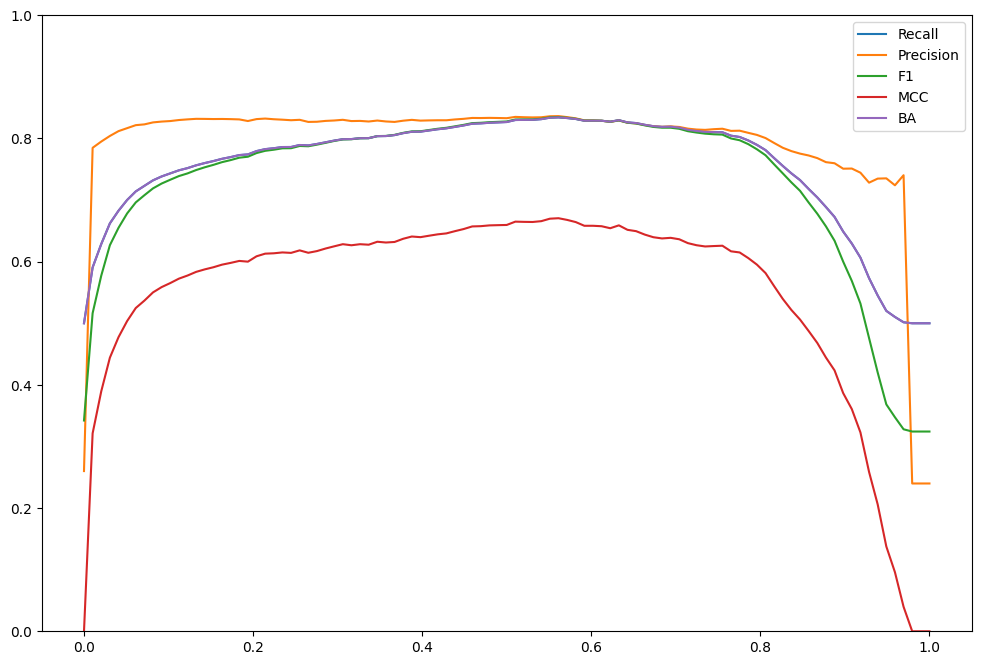

In [39]:
plt.figure(figsize = (12, 8))
plt.ylim(0, 1)
sns.lineplot(x = thresholds, y = recalls, label = 'Recall')
sns.lineplot(x = thresholds, y = precisions, label = 'Precision')
sns.lineplot(x = thresholds, y = f1s, label = 'F1')
sns.lineplot(x = thresholds, y = mccs, label = 'MCC')
sns.lineplot(x = thresholds, y = bas, label = 'BA')
plt.legend()

In [40]:
print(roc_auc_score(y_test, y_probas))

0.9051762179336315


<Axes: ylabel='Count'>

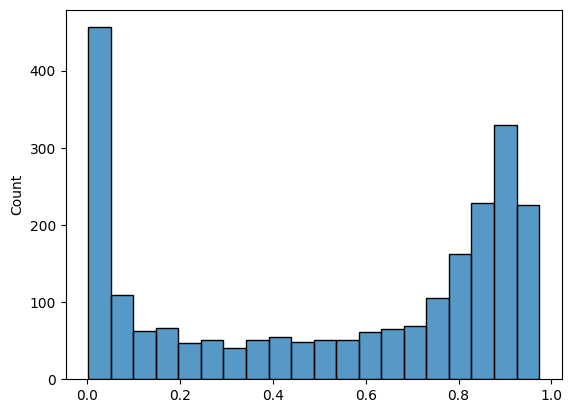

In [41]:
sns.histplot(x = y_probas, bins = 20)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

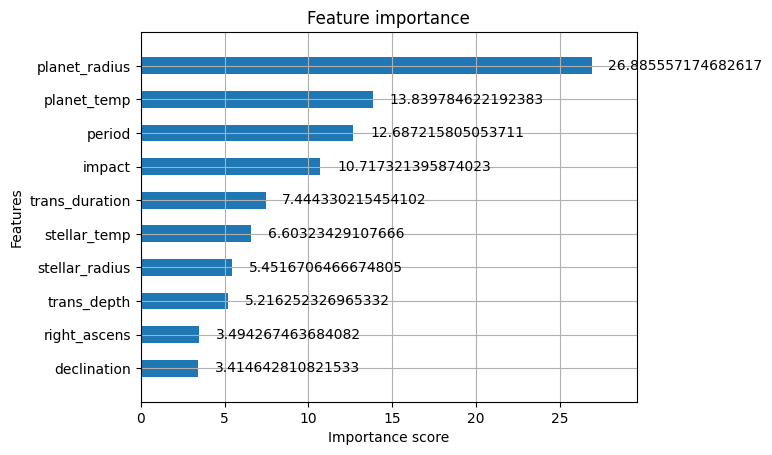

In [42]:
xgboost.plot_importance(xgbmodel, importance_type="gain", height=0.5)